In [1]:
import sys
import os
import json
import optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from typing import Tuple
from keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. EDA

In [2]:
df_ts = pd.read_csv('imputed_Global.csv')

In [3]:
df_ts.head()

,Index,LandAverageTemperature
0,Jan 1750,3.034
1,Feb 1750,3.083
2,Mar 1750,5.626
3,Apr 1750,8.490
4,May 1750,11.573


In [4]:
df_ts.isna().sum()

Index                     0
LandAverageTemperature    0
dtype: int64

In [5]:
df_ts.shape

(3192, 2)

In [6]:
df_ts.dtypes

Index                      object
LandAverageTemperature    float64
dtype: object

In [7]:
df_ts['Index'] = pd.to_datetime(df_ts['Index'])
df_ts.sort_values(by='Index', inplace=True)

In [8]:
df_ts.head()

,Index,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573


<AxesSubplot:xlabel='Index', ylabel='LandAverageTemperature'>

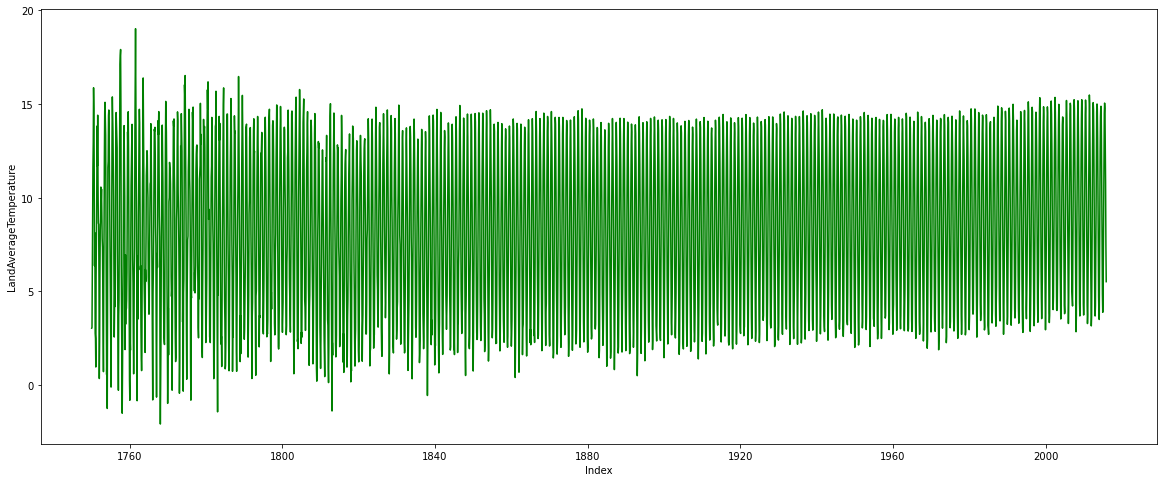

In [9]:
plt.figure(figsize=(20,8))
sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df_ts)

## 2. Helper functions

In [10]:
#train-test split
def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_period: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    x_train = X
    x_test = []

    Y_train = Y
    Y_test = []

    if test_period > 0:
        index = test_period
        x_train = X[: (len(X) - index)]
        x_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return x_train, x_test, Y_train, Y_test

In [11]:
# plot loss function and rmse history
def history(model, title='Train v.s. Validation'):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['root_mean_squared_error'], color = 'blue', label='train')
    plt.plot(model.history['val_root_mean_squared_error'], color='red', label='valid')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

In [12]:
#smape
def smape(a, f):
    return 1/len(a) * np.sum(2*np.abs(f-a)/(np.abs(a)+np.abs(f)))

## Fit a single layer LSTM with lag = 3 months

In [13]:
lag = 3
test_period = 36

X_train_3, X_test_3, y_train_3, y_test_3 = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [14]:
model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units=128, input_shape=X_train_3.shape[1:]))
model_lstm_3.add(Dense(units=1, activation='relu'))
model_lstm_3.compile(loss='mse', optimizer='sgd', metrics=[keras.metrics.RootMeanSquaredError()])

In [15]:
checkpointer = ModelCheckpoint(filepath='weights_compare_lstm3.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_lstm3 = model_lstm_3.fit(X_train_3, y_train_3, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000


2022-05-29 18:43:29.527645: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


74/74 [==============================] - 1s 4ms/step - loss: 86.2479 - root_mean_squared_error: 9.2870 - val_loss: 24.5090 - val_root_mean_squared_error: 4.9507
Epoch 2/1000
74/74 [==============================] - 0s 2ms/step - loss: 7.7796 - root_mean_squared_error: 2.7892 - val_loss: 4.0498 - val_root_mean_squared_error: 2.0124
Epoch 3/1000
74/74 [==============================] - 0s 2ms/step - loss: 2.9611 - root_mean_squared_error: 1.7208 - val_loss: 0.4117 - val_root_mean_squared_error: 0.6417
Epoch 4/1000
74/74 [==============================] - 0s 2ms/step - loss: 2.1810 - root_mean_squared_error: 1.4768 - val_loss: 0.4146 - val_root_mean_squared_error: 0.6439
Epoch 5/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.9361 - root_mean_squared_error: 1.3914 - val_loss: 0.4851 - val_root_mean_squared_error: 0.6965
Epoch 6/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.9198 - root_mean_squared_error: 1.3856 - val_loss: 0.8351 - val_root_mean_s

74/74 [==============================] - 0s 2ms/step - loss: 1.2277 - root_mean_squared_error: 1.1080 - val_loss: 0.6293 - val_root_mean_squared_error: 0.7933
Epoch 49/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.2461 - root_mean_squared_error: 1.1163 - val_loss: 1.0705 - val_root_mean_squared_error: 1.0346


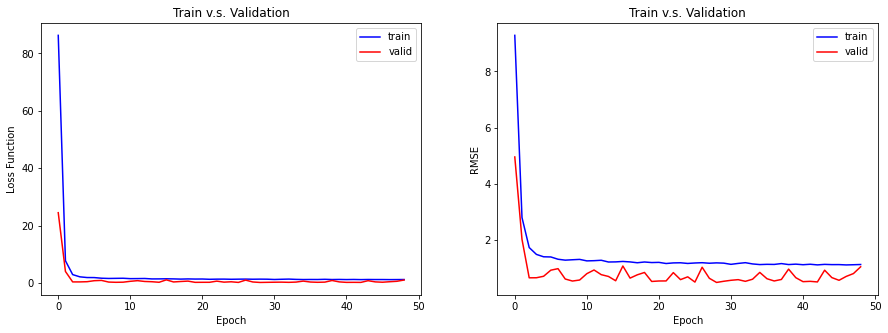

In [16]:
history(history_lstm3)

In [17]:
model_lstm_3.load_weights('weights_compare_lstm3.hdf5')

In [18]:
score_lstm_3 = model_lstm_3.evaluate(X_test_3, y_test_3, batch_size=32)
print('Test Loss: ', score_lstm_3[0])
print('Test RMSE: ', score_lstm_3[1])

2/2 [==============================] - 0s 877us/step - loss: 0.4345 - root_mean_squared_error: 0.6591
Test Loss:  0.4344758987426758
Test RMSE:  0.6591478586196899


In [19]:
y_pred_3 = model_lstm_3.predict(X_test_3)

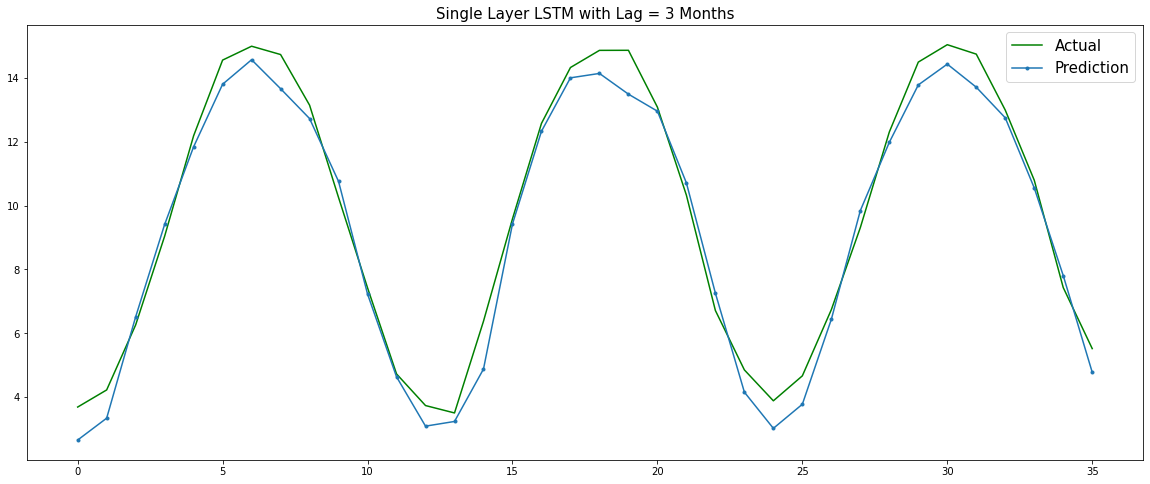

In [20]:
plt.figure(figsize=(20,8))
plt.plot(y_test_3, 'g', label='Actual')
plt.plot(y_pred_3, marker='.', label='Prediction')
plt.title('Single Layer LSTM with Lag = 3 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 3 months

In [53]:
model_blstm_3 = Sequential()
model_blstm_3.add(Bidirectional(LSTM(units=128, input_shape=X_train_3.shape[1:])))
model_blstm_3.add(Dense(units=1, activation='relu'))
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_blstm_3.compile(loss='mse', optimizer=sgd, metrics=[keras.metrics.RootMeanSquaredError()])

In [54]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm3.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm3 = model_blstm_3.fit(X_train_3, y_train_3, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 1s 6ms/step - loss: 24.5871 - root_mean_squared_error: 4.9585 - val_loss: 11.7728 - val_root_mean_squared_error: 3.4312
Epoch 2/1000
74/74 [==============================] - 0s 3ms/step - loss: 12.6912 - root_mean_squared_error: 3.5625 - val_loss: 9.9528 - val_root_mean_squared_error: 3.1548
Epoch 3/1000
74/74 [==============================] - 0s 3ms/step - loss: 10.9041 - root_mean_squared_error: 3.3021 - val_loss: 8.4556 - val_root_mean_squared_error: 2.9079
Epoch 4/1000
74/74 [==============================] - 0s 3ms/step - loss: 9.2470 - root_mean_squared_error: 3.0409 - val_loss: 7.0483 - val_root_mean_squared_error: 2.6549
Epoch 5/1000
74/74 [==============================] - 0s 3ms/step - loss: 7.6539 - root_mean_squared_error: 2.7666 - val_loss: 5.3839 - val_root_mean_squared_error: 2.3203
Epoch 6/1000
74/74 [==============================] - 0s 3ms/step - loss: 6.0588 - root_mean_squared_error: 2.4615 - val_loss: 3.9645 - 

74/74 [==============================] - 0s 3ms/step - loss: 1.3056 - root_mean_squared_error: 1.1426 - val_loss: 0.3042 - val_root_mean_squared_error: 0.5515
Epoch 49/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.2990 - root_mean_squared_error: 1.1397 - val_loss: 0.3498 - val_root_mean_squared_error: 0.5914
Epoch 50/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.3006 - root_mean_squared_error: 1.1404 - val_loss: 0.3115 - val_root_mean_squared_error: 0.5581
Epoch 51/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.2918 - root_mean_squared_error: 1.1366 - val_loss: 0.3152 - val_root_mean_squared_error: 0.5615
Epoch 52/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.2935 - root_mean_squared_error: 1.1373 - val_loss: 0.2976 - val_root_mean_squared_error: 0.5455
Epoch 53/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.2928 - root_mean_squared_error: 1.1370 - val_loss: 0.3002 - val_root_mea

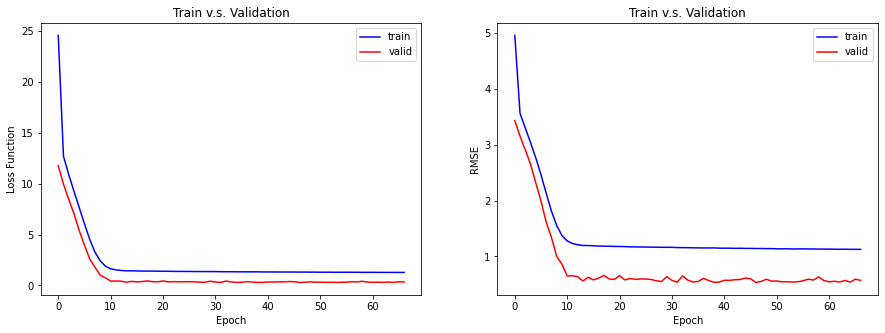

In [55]:
history(history_blstm3)

In [56]:
model_blstm_3.load_weights('weights_compare_blstm3.hdf5')

In [57]:
score_blstm_3 = model_blstm_3.evaluate(X_test_3, y_test_3, batch_size=32)
print('Test Loss: ', score_blstm_3[0])
print('Test RMSE: ', score_blstm_3[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.5287 - root_mean_squared_error: 0.7271
Test Loss:  0.5287255644798279
Test RMSE:  0.727135181427002


In [58]:
y_pred_3 = model_blstm_3.predict(X_test_3)

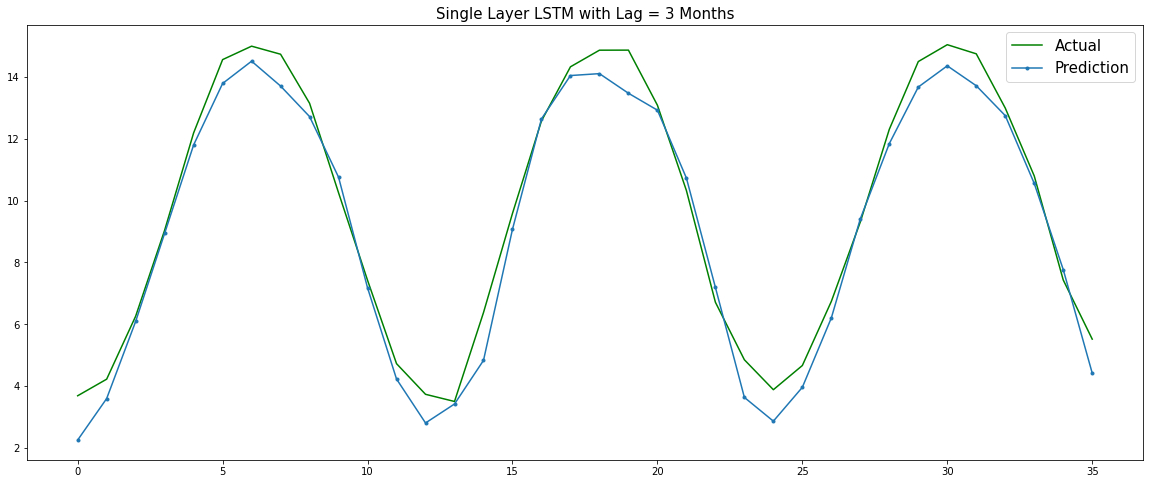

In [59]:
plt.figure(figsize=(20,8))
plt.plot(y_test_3, 'g', label='Actual')
plt.plot(y_pred_3, marker='.', label='Prediction')
plt.title('Single Layer LSTM with Lag = 3 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a single layer LSTM with lag = 12 months

In [60]:
lag = 12
test_period = 36

X_train, X_test, y_train, y_test = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [61]:
model_lstm_12 = Sequential()
model_lstm_12.add(LSTM(units=128, input_shape=X_train.shape[1:]))
model_lstm_12.add(Dense(units=1, activation='relu'))
model_lstm_12.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [62]:
checkpointer = ModelCheckpoint(filepath='weights_compare_lstm12.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_lstm12 = model_lstm_12.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 1s 9ms/step - loss: 23.8571 - root_mean_squared_error: 4.8844 - val_loss: 12.6967 - val_root_mean_squared_error: 3.5632
Epoch 2/1000
74/74 [==============================] - 0s 6ms/step - loss: 8.1013 - root_mean_squared_error: 2.8463 - val_loss: 1.3087 - val_root_mean_squared_error: 1.1440
Epoch 3/1000
74/74 [==============================] - 0s 6ms/step - loss: 1.0859 - root_mean_squared_error: 1.0421 - val_loss: 1.5859 - val_root_mean_squared_error: 1.2593
Epoch 4/1000
74/74 [==============================] - 0s 6ms/step - loss: 1.0307 - root_mean_squared_error: 1.0152 - val_loss: 0.6370 - val_root_mean_squared_error: 0.7981
Epoch 5/1000
74/74 [==============================] - 0s 6ms/step - loss: 0.9221 - root_mean_squared_error: 0.9603 - val_loss: 0.6254 - val_root_mean_squared_error: 0.7908
Epoch 6/1000
74/74 [==============================] - 0s 7ms/step - loss: 0.9054 - root_mean_squared_error: 0.9515 - val_loss: 0.4426 - va

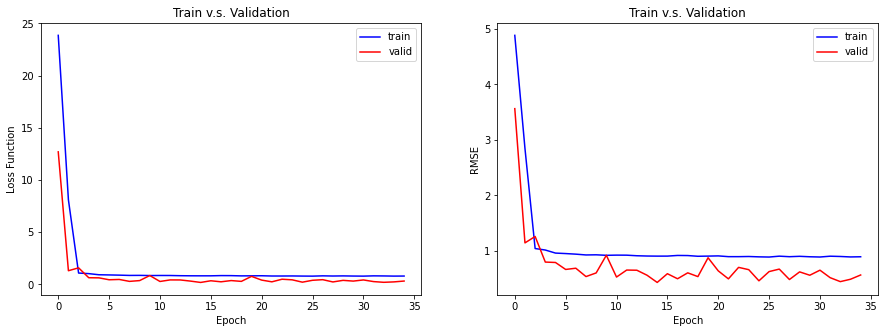

In [63]:
history(history_lstm12)

In [64]:
model_lstm_12.load_weights('weights_compare_lstm12.hdf5')
score_lstm_12 = model_lstm_12.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_lstm_12[0])
print('Test RMSE: ', score_lstm_12[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.5189 - root_mean_squared_error: 0.7204
Test Loss:  0.5189439654350281
Test RMSE:  0.7203776836395264


In [65]:
y_pred = model_lstm_12.predict(X_test)

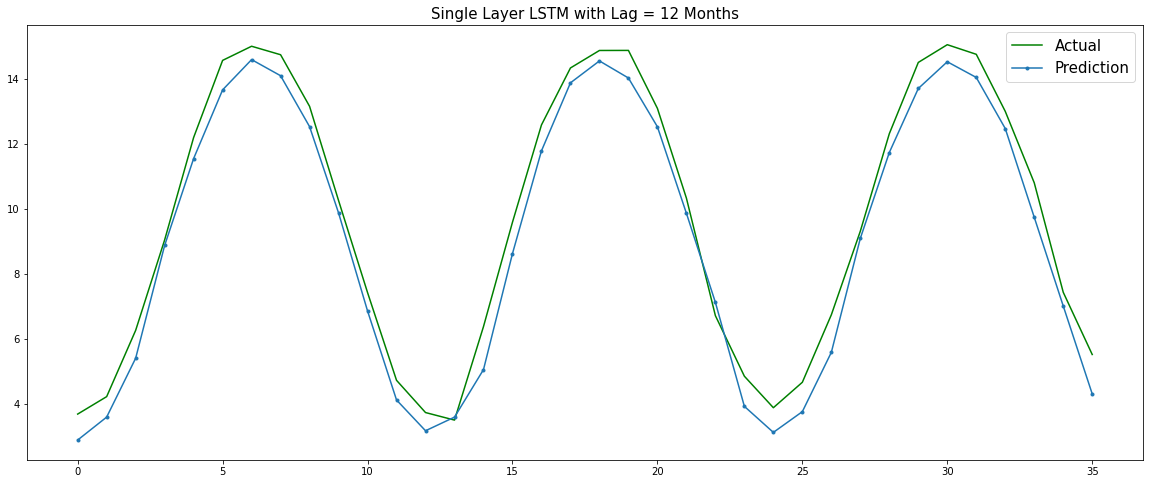

In [66]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Single Layer LSTM with Lag = 12 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 12 months

In [35]:
model_blstm_12 = Sequential()
model_blstm_12.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
model_blstm_12.add(Dense(units=1, activation='relu'))
model_blstm_12.compile(loss='mse', optimizer='sgd', metrics=[keras.metrics.RootMeanSquaredError()])

In [36]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm12.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm12 = model_blstm_12.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 2s 10ms/step - loss: 4.9040 - root_mean_squared_error: 2.2145 - val_loss: 0.1796 - val_root_mean_squared_error: 0.4238
Epoch 2/1000
74/74 [==============================] - 0s 6ms/step - loss: 1.2416 - root_mean_squared_error: 1.1143 - val_loss: 0.3452 - val_root_mean_squared_error: 0.5875
Epoch 3/1000
74/74 [==============================] - 0s 7ms/step - loss: 1.0146 - root_mean_squared_error: 1.0073 - val_loss: 0.2773 - val_root_mean_squared_error: 0.5266
Epoch 4/1000
74/74 [==============================] - 0s 7ms/step - loss: 1.0367 - root_mean_squared_error: 1.0182 - val_loss: 0.4053 - val_root_mean_squared_error: 0.6367
Epoch 5/1000
74/74 [==============================] - 1s 7ms/step - loss: 0.9895 - root_mean_squared_error: 0.9947 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168
Epoch 6/1000
74/74 [==============================] - 1s 7ms/step - loss: 0.9797 - root_mean_squared_error: 0.9898 - val_loss: 0.4502 - val

74/74 [==============================] - 1s 8ms/step - loss: 0.8247 - root_mean_squared_error: 0.9081 - val_loss: 0.1346 - val_root_mean_squared_error: 0.3669
Epoch 49/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8242 - root_mean_squared_error: 0.9078 - val_loss: 0.1932 - val_root_mean_squared_error: 0.4396
Epoch 50/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8182 - root_mean_squared_error: 0.9045 - val_loss: 0.1427 - val_root_mean_squared_error: 0.3778
Epoch 51/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8001 - root_mean_squared_error: 0.8945 - val_loss: 0.1301 - val_root_mean_squared_error: 0.3608


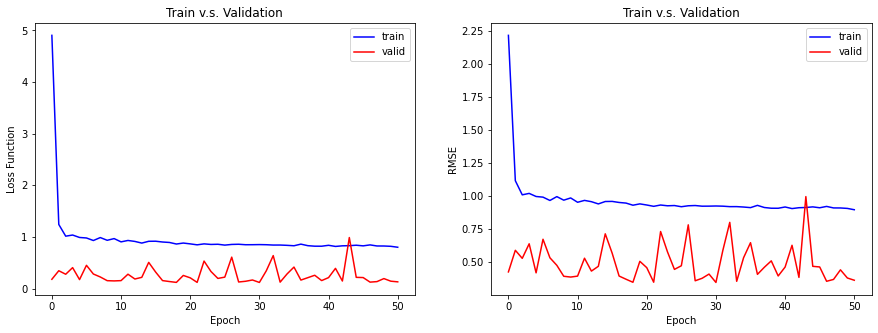

In [37]:
history(history_blstm12)

In [38]:
model_blstm_12.load_weights('weights_compare_blstm12.hdf5')
score_blstm_12 = model_blstm_12.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_blstm_12[0])
print('Test RMSE: ', score_blstm_12[1])

2/2 [==============================] - 0s 2ms/step - loss: 0.1560 - root_mean_squared_error: 0.3950
Test Loss:  0.15599510073661804
Test RMSE:  0.3949621617794037


In [39]:
y_pred = model_blstm_12.predict(X_test)

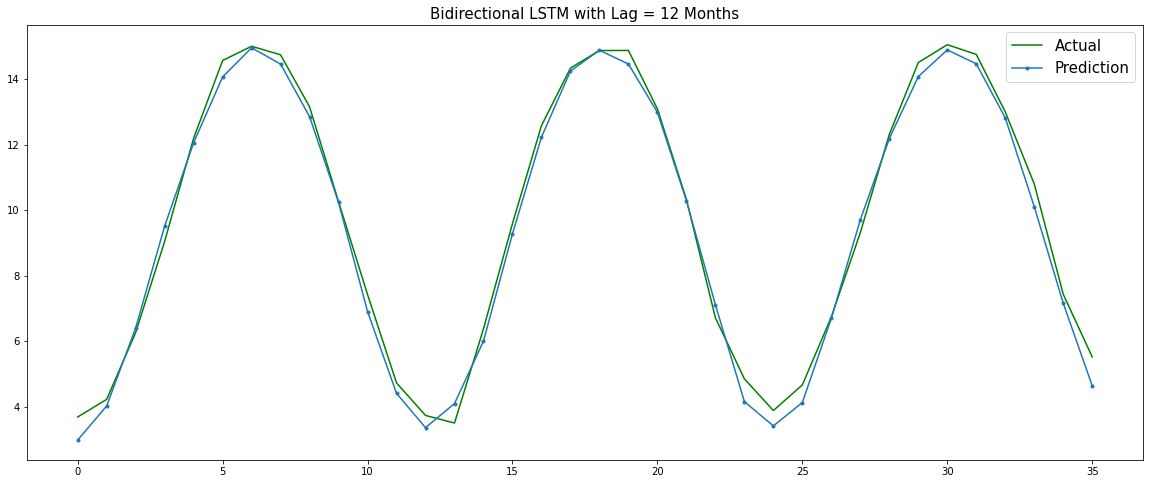

In [40]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Bidirectional LSTM with Lag = 12 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 24 months

In [41]:
lag = 24
test_period = 36

X_train, X_test, y_train, y_test = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [42]:
model_blstm_0 = Sequential()
model_blstm_0.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
model_blstm_0.add(Dense(units=1, activation='relu'))
model_blstm_0.compile(loss='mse', optimizer='sgd', metrics=[keras.metrics.RootMeanSquaredError()])

In [43]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm0.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm0 = model_blstm_0.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 2s 15ms/step - loss: 4.6045 - root_mean_squared_error: 2.1458 - val_loss: 0.5817 - val_root_mean_squared_error: 0.7627
Epoch 2/1000
74/74 [==============================] - 1s 13ms/step - loss: 1.3031 - root_mean_squared_error: 1.1415 - val_loss: 0.1717 - val_root_mean_squared_error: 0.4143
Epoch 3/1000
74/74 [==============================] - 1s 15ms/step - loss: 1.1600 - root_mean_squared_error: 1.0770 - val_loss: 0.1841 - val_root_mean_squared_error: 0.4290
Epoch 4/1000
74/74 [==============================] - 1s 16ms/step - loss: 1.1032 - root_mean_squared_error: 1.0503 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969
Epoch 5/1000
74/74 [==============================] - 1s 17ms/step - loss: 1.1244 - root_mean_squared_error: 1.0604 - val_loss: 0.1388 - val_root_mean_squared_error: 0.3726
Epoch 6/1000
74/74 [==============================] - 1s 16ms/step - loss: 1.0436 - root_mean_squared_error: 1.0216 - val_loss: 0.8054 

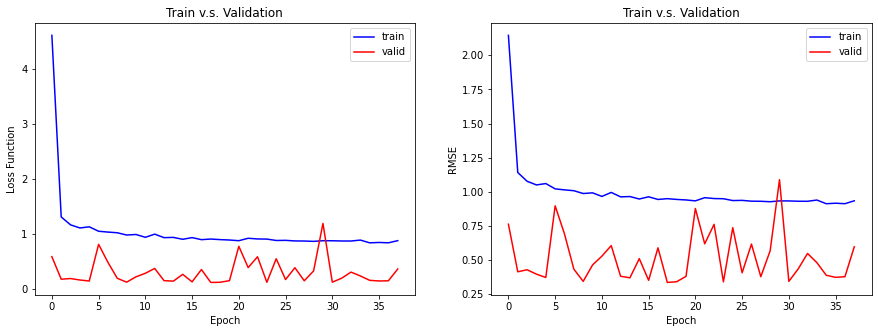

In [44]:
history(history_blstm0)

In [45]:
model_blstm_0.load_weights('weights_compare_blstm0.hdf5')
score_blstm_0 = model_blstm_0.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_blstm_0[0])
print('Test RMSE: ', score_blstm_0[1])

2/2 [==============================] - 0s 2ms/step - loss: 0.1032 - root_mean_squared_error: 0.3212
Test Loss:  0.10315920412540436
Test RMSE:  0.32118406891822815


In [46]:
y_pred = model_blstm_0.predict(X_test)

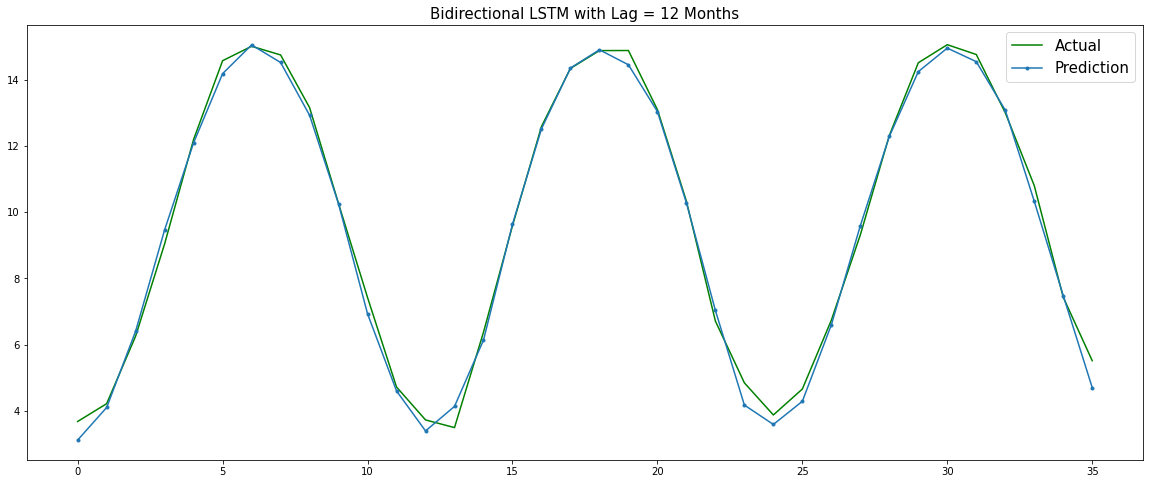

In [47]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Bidirectional LSTM with Lag = 12 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Major City Comparison

In [48]:
def ts_plot(name):
    df = pd.read_csv(f'major_city/{name}.csv', header=None)
    df.rename(columns={0:'Index', 1:'LandAverageTemperature'}, inplace=True)
    df['Index'] = pd.to_datetime(df['Index'])
    df.sort_values(by='Index', inplace=True)
    plt.figure(figsize=(20,8))
    sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df)
    plt.title(name, size=15)

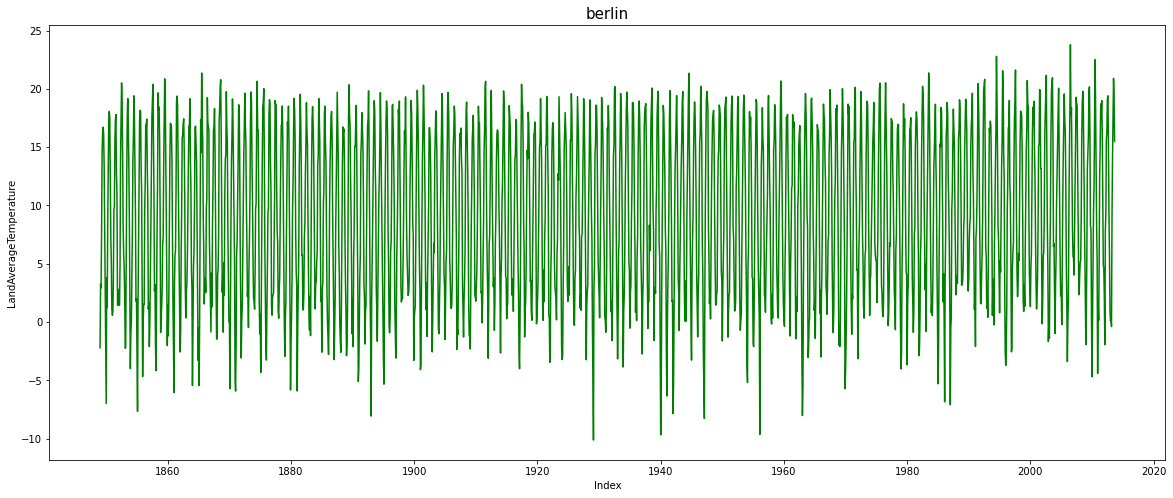

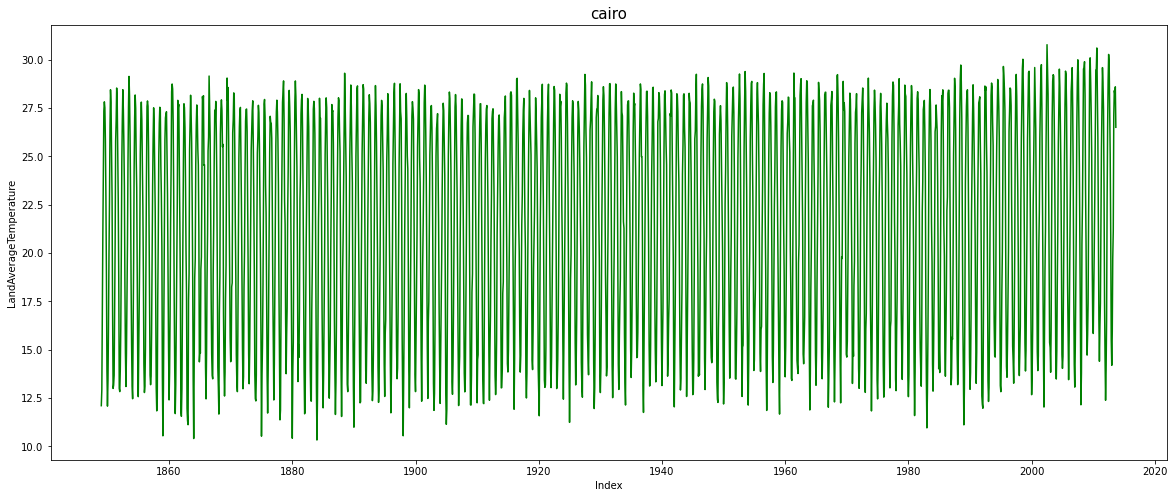

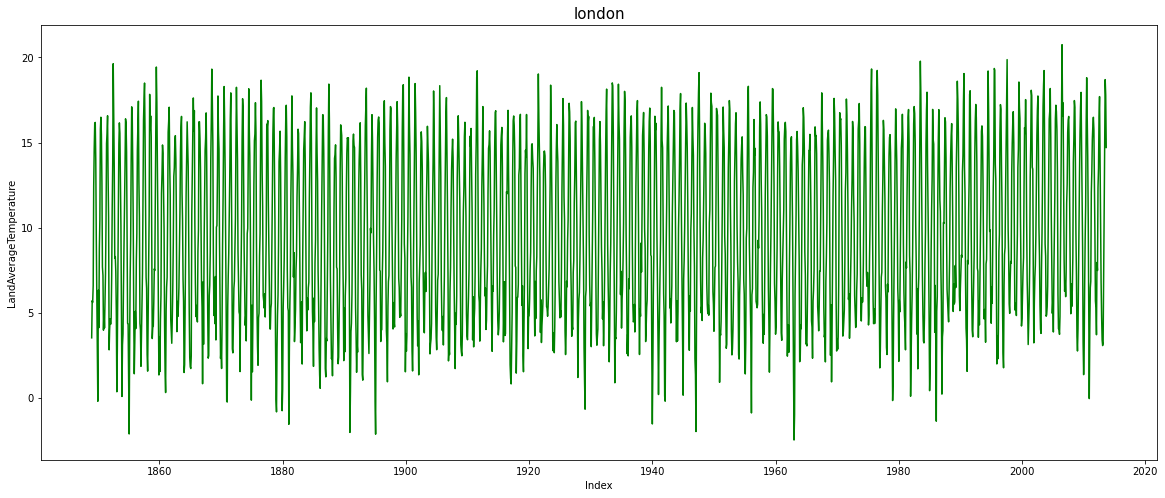

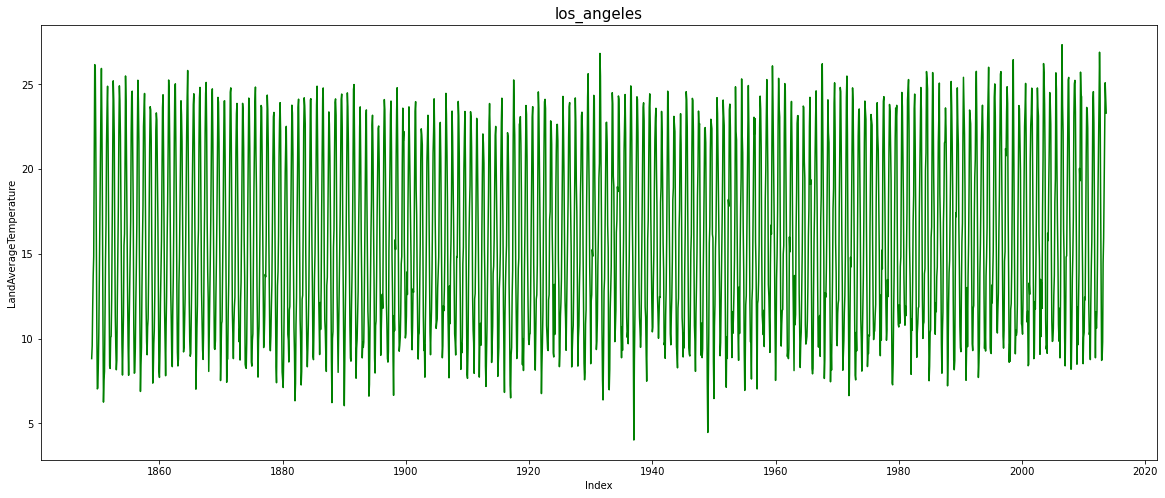

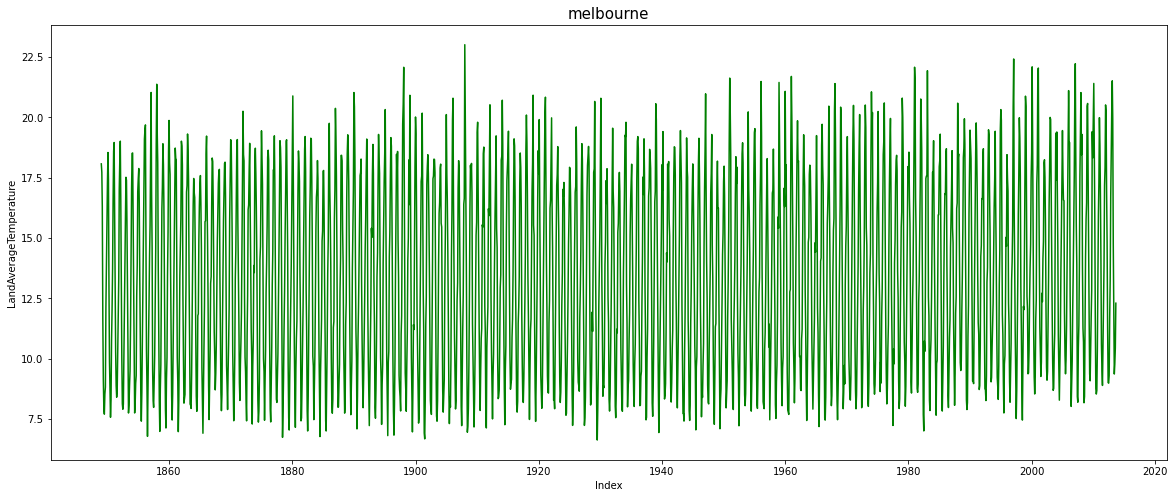

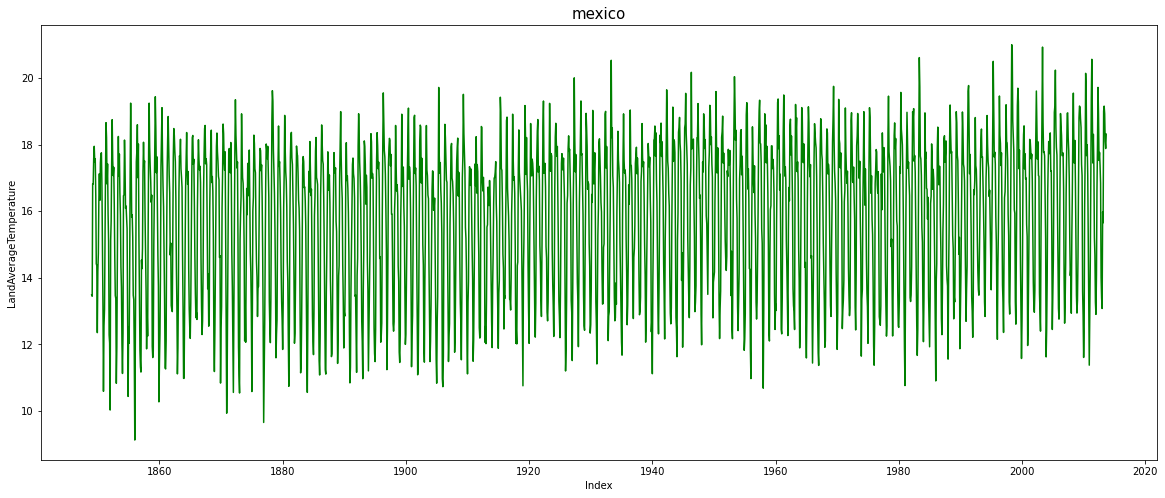

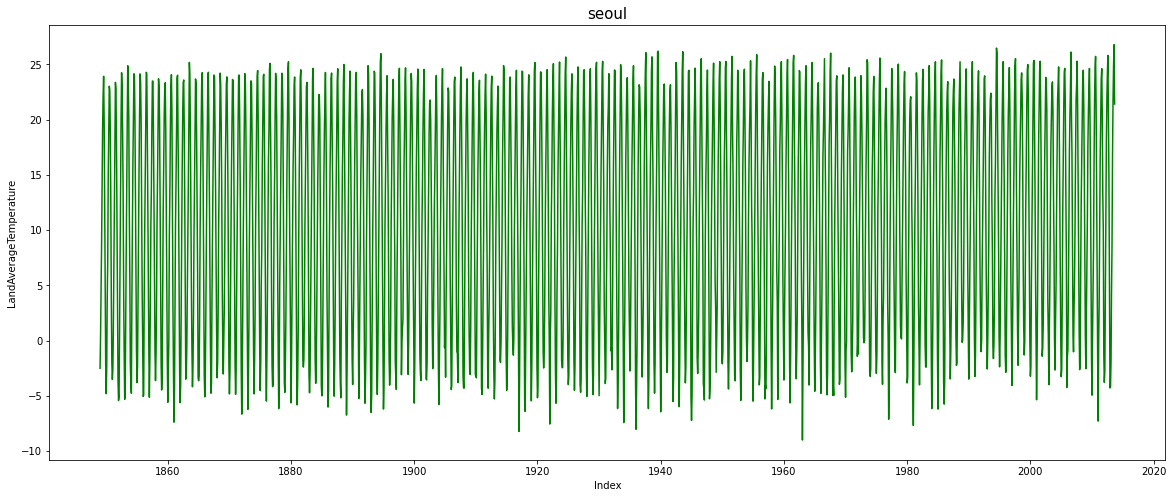

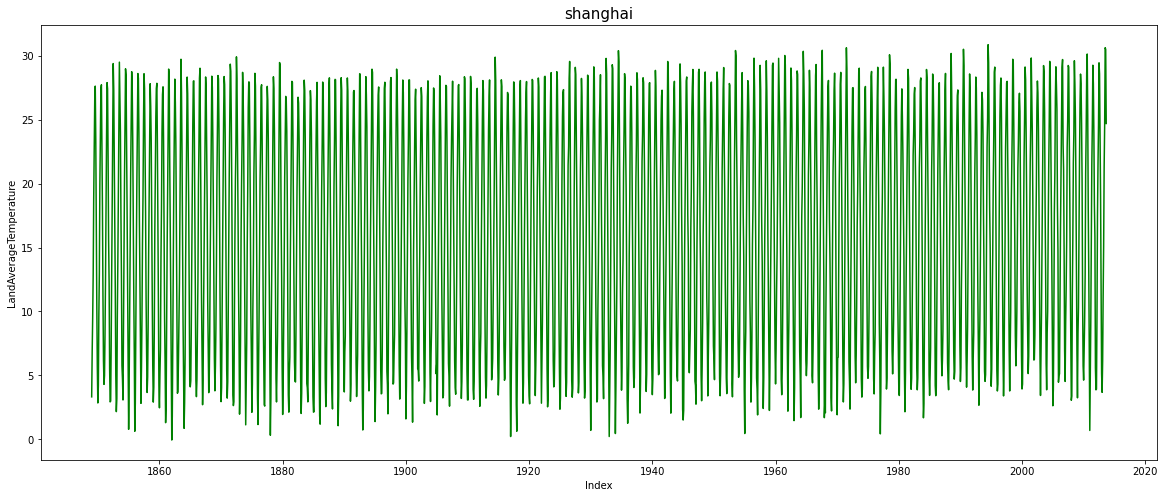

In [49]:
city = ['berlin', 'cairo', 'london', 'los_angeles', 'melbourne', 'mexico', 'seoul', 'shanghai']
for i in city:
    ts_plot(i)

In [52]:
lag = 12
test_period = 36
def city_model(name):
    df = pd.read_csv(f'major_city/{name}.csv', header=None)
    df.rename(columns={0:'Index', 1:'LandAverageTemperature'}, inplace=True)
    df['Index'] = pd.to_datetime(df['Index'])
    df.sort_values(by='Index', inplace=True)
    X_train, X_test, y_train, y_test = create_data_for_NN(df, df.columns[-1], lag, test_period)
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer='sgd', metrics=[keras.metrics.RootMeanSquaredError(), ])
    checkpointer = ModelCheckpoint(filepath=f'weights_compare_{name}.hdf5', save_best_only=True)
    checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
    history_city = model.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                     callbacks=[checkpointer,checkimprovement])
    history(history_city, name)
    model.load_weights(f'weights_compare_{name}.hdf5')
    score = model.evaluate(X_test, y_test, batch_size=32)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(20,8))
    plt.plot(y_test, 'g', label='Actual')
    plt.plot(y_pred, marker='.', label='Prediction')
    plt.title(name, size=15)
    plt.legend(fontsize=15)
    plt.show()
    print('Test Loss: ', score[0])
    print('Test RMSE: ', score[1])
    return score

Epoch 1/1000
46/46 [==============================] - 2s 14ms/step - loss: 12.7503 - root_mean_squared_error: 3.5708 - val_loss: 4.8929 - val_root_mean_squared_error: 2.2120
Epoch 2/1000
46/46 [==============================] - 0s 8ms/step - loss: 5.2206 - root_mean_squared_error: 2.2849 - val_loss: 4.1972 - val_root_mean_squared_error: 2.0487
Epoch 3/1000
46/46 [==============================] - 0s 8ms/step - loss: 5.0647 - root_mean_squared_error: 2.2505 - val_loss: 6.4426 - val_root_mean_squared_error: 2.5382
Epoch 4/1000
46/46 [==============================] - 0s 8ms/step - loss: 4.8989 - root_mean_squared_error: 2.2133 - val_loss: 4.3310 - val_root_mean_squared_error: 2.0811
Epoch 5/1000
46/46 [==============================] - 0s 9ms/step - loss: 4.6945 - root_mean_squared_error: 2.1667 - val_loss: 4.5723 - val_root_mean_squared_error: 2.1383
Epoch 6/1000
46/46 [==============================] - 0s 8ms/step - loss: 4.7743 - root_mean_squared_error: 2.1850 - val_loss: 4.9231 - va

46/46 [==============================] - 0s 7ms/step - loss: 4.2730 - root_mean_squared_error: 2.0671 - val_loss: 6.1716 - val_root_mean_squared_error: 2.4843
Epoch 49/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.2322 - root_mean_squared_error: 2.0572 - val_loss: 3.8860 - val_root_mean_squared_error: 1.9713
Epoch 50/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.1769 - root_mean_squared_error: 2.0437 - val_loss: 4.3516 - val_root_mean_squared_error: 2.0861
Epoch 51/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.2702 - root_mean_squared_error: 2.0665 - val_loss: 6.4901 - val_root_mean_squared_error: 2.5476
Epoch 52/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.1761 - root_mean_squared_error: 2.0435 - val_loss: 5.2258 - val_root_mean_squared_error: 2.2860
Epoch 53/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.2168 - root_mean_squared_error: 2.0535 - val_loss: 4.4398 - val_root_mea

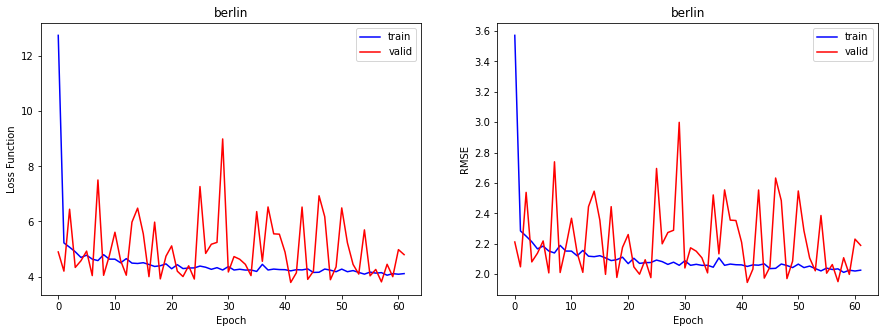

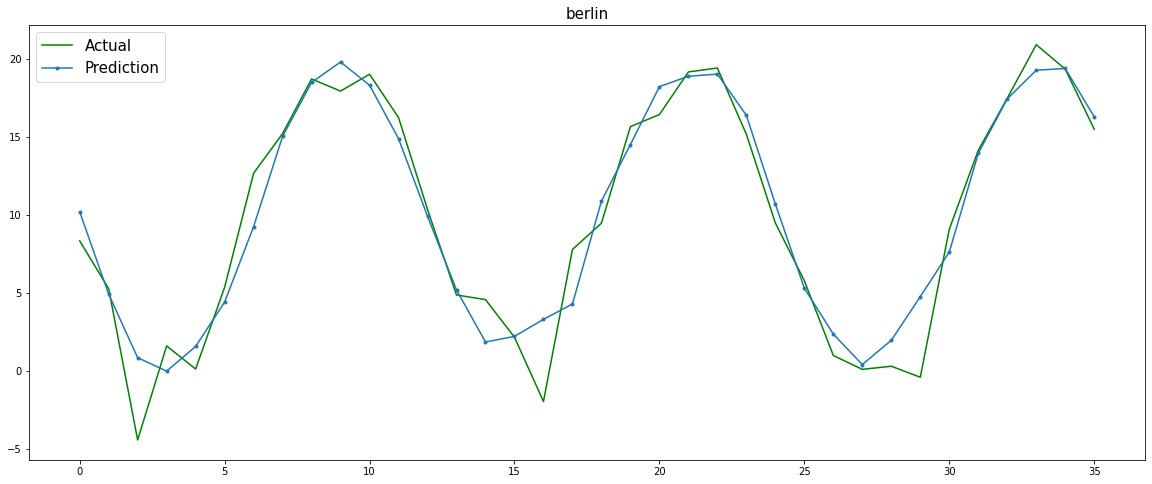

Test Loss:  4.1316070556640625
Test RMSE:  2.032635450363159


In [67]:
berlin_score = city_model('berlin')

Epoch 1/1000
46/46 [==============================] - 2s 13ms/step - loss: 38.4101 - root_mean_squared_error: 6.1976 - val_loss: 13.6207 - val_root_mean_squared_error: 3.6906
Epoch 2/1000
46/46 [==============================] - 0s 8ms/step - loss: 19.4397 - root_mean_squared_error: 4.4090 - val_loss: 49.2381 - val_root_mean_squared_error: 7.0170
Epoch 3/1000
46/46 [==============================] - 0s 8ms/step - loss: 17.1031 - root_mean_squared_error: 4.1356 - val_loss: 9.6739 - val_root_mean_squared_error: 3.1103
Epoch 4/1000
46/46 [==============================] - 0s 8ms/step - loss: 14.3158 - root_mean_squared_error: 3.7836 - val_loss: 22.6553 - val_root_mean_squared_error: 4.7598
Epoch 5/1000
46/46 [==============================] - 0s 8ms/step - loss: 9.2163 - root_mean_squared_error: 3.0358 - val_loss: 4.0920 - val_root_mean_squared_error: 2.0229
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 8.0305 - root_mean_squared_error: 2.8338 - val_loss: 4.841

46/46 [==============================] - 0s 8ms/step - loss: 2.1369 - root_mean_squared_error: 1.4618 - val_loss: 1.3404 - val_root_mean_squared_error: 1.1577
Epoch 49/1000
46/46 [==============================] - 0s 9ms/step - loss: 2.7420 - root_mean_squared_error: 1.6559 - val_loss: 1.4047 - val_root_mean_squared_error: 1.1852
Epoch 50/1000
46/46 [==============================] - 0s 9ms/step - loss: 1.8106 - root_mean_squared_error: 1.3456 - val_loss: 5.3551 - val_root_mean_squared_error: 2.3141
Epoch 51/1000
46/46 [==============================] - 0s 8ms/step - loss: 2.0759 - root_mean_squared_error: 1.4408 - val_loss: 1.5554 - val_root_mean_squared_error: 1.2472
Epoch 52/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.7617 - root_mean_squared_error: 1.3273 - val_loss: 1.5812 - val_root_mean_squared_error: 1.2575
Epoch 53/1000
46/46 [==============================] - 0s 8ms/step - loss: 2.6798 - root_mean_squared_error: 1.6370 - val_loss: 1.7649 - val_root_mea

46/46 [==============================] - 0s 8ms/step - loss: 1.9322 - root_mean_squared_error: 1.3900 - val_loss: 1.1974 - val_root_mean_squared_error: 1.0943
Epoch 96/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.1367 - root_mean_squared_error: 1.4618 - val_loss: 1.3515 - val_root_mean_squared_error: 1.1625
Epoch 97/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.5764 - root_mean_squared_error: 1.2556 - val_loss: 1.8281 - val_root_mean_squared_error: 1.3521
Epoch 98/1000
46/46 [==============================] - 0s 9ms/step - loss: 1.3498 - root_mean_squared_error: 1.1618 - val_loss: 1.7386 - val_root_mean_squared_error: 1.3186
Epoch 99/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.4531 - root_mean_squared_error: 1.2054 - val_loss: 1.3163 - val_root_mean_squared_error: 1.1473
Epoch 100/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.5250 - root_mean_squared_error: 1.2349 - val_loss: 2.4898 - val_root_me

46/46 [==============================] - 0s 8ms/step - loss: 1.4044 - root_mean_squared_error: 1.1851 - val_loss: 2.8612 - val_root_mean_squared_error: 1.6915
Epoch 143/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.2439 - root_mean_squared_error: 1.1153 - val_loss: 4.1883 - val_root_mean_squared_error: 2.0465
Epoch 144/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.5306 - root_mean_squared_error: 1.2372 - val_loss: 1.0878 - val_root_mean_squared_error: 1.0430
Epoch 145/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.2482 - root_mean_squared_error: 1.1173 - val_loss: 1.6792 - val_root_mean_squared_error: 1.2958
Epoch 146/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.5157 - root_mean_squared_error: 1.2312 - val_loss: 1.3143 - val_root_mean_squared_error: 1.1464
Epoch 147/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.2780 - root_mean_squared_error: 1.1305 - val_loss: 1.1833 - val_roo

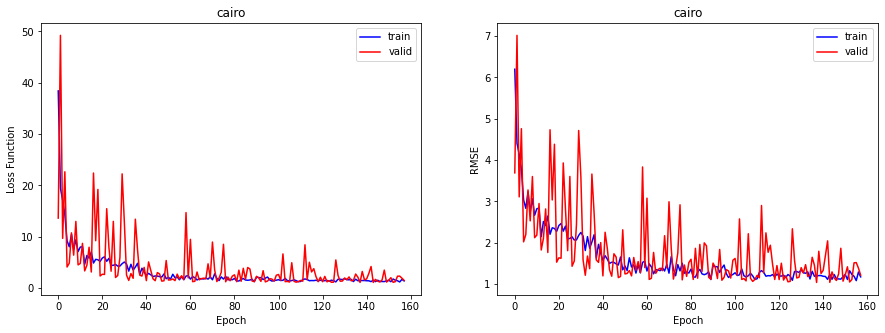

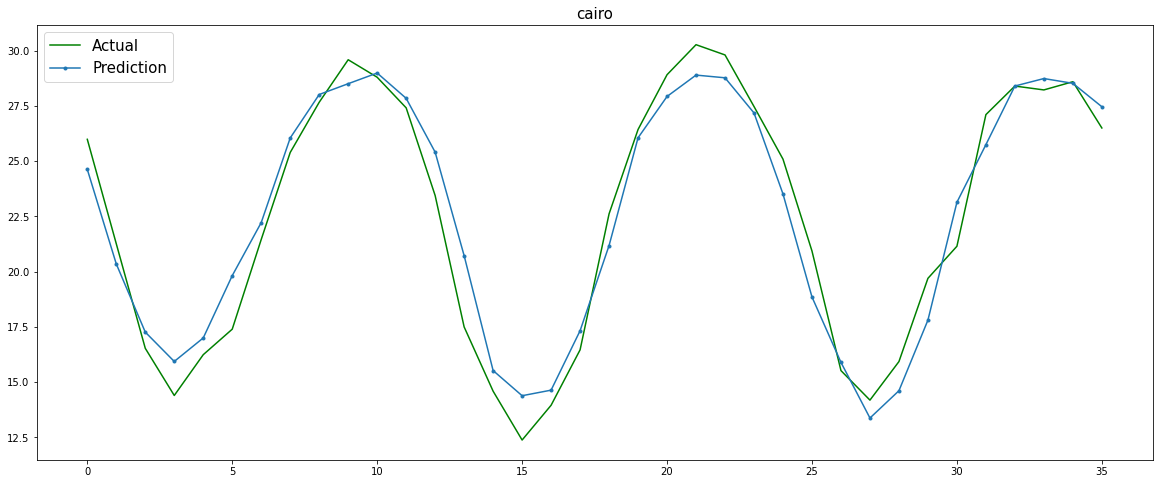

Test Loss:  1.69473135471344
Test RMSE:  1.3018184900283813


In [68]:
cairo_score = city_model('cairo')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 12.2406 - root_mean_squared_error: 3.4987 - val_loss: 3.8528 - val_root_mean_squared_error: 1.9628
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.6139 - root_mean_squared_error: 1.9010 - val_loss: 2.7751 - val_root_mean_squared_error: 1.6659
Epoch 3/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.9590 - root_mean_squared_error: 1.7202 - val_loss: 6.4919 - val_root_mean_squared_error: 2.5479
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.9757 - root_mean_squared_error: 1.7250 - val_loss: 2.8310 - val_root_mean_squared_error: 1.6826
Epoch 5/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.8211 - root_mean_squared_error: 1.6796 - val_loss: 2.0964 - val_root_mean_squared_error: 1.4479
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.5201 - root_mean_squared_error: 1.5875 - val_loss: 2.6886 - va

46/46 [==============================] - 0s 6ms/step - loss: 2.1423 - root_mean_squared_error: 1.4637 - val_loss: 2.1603 - val_root_mean_squared_error: 1.4698
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.1952 - root_mean_squared_error: 1.4816 - val_loss: 1.9434 - val_root_mean_squared_error: 1.3940
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.0849 - root_mean_squared_error: 1.4439 - val_loss: 1.8916 - val_root_mean_squared_error: 1.3754
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.0934 - root_mean_squared_error: 1.4468 - val_loss: 2.3674 - val_root_mean_squared_error: 1.5386
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.1235 - root_mean_squared_error: 1.4572 - val_loss: 1.9081 - val_root_mean_squared_error: 1.3813
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.1084 - root_mean_squared_error: 1.4520 - val_loss: 2.1726 - val_root_mea

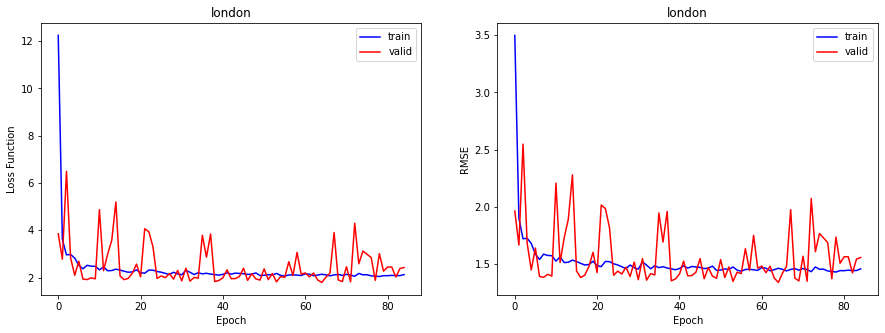

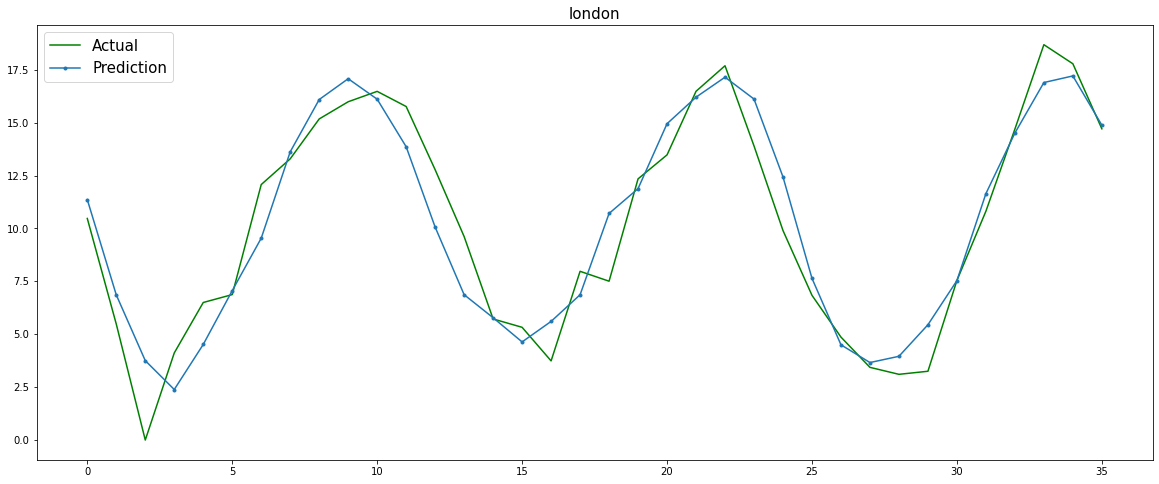

Test Loss:  2.5405402183532715
Test RMSE:  1.5939072370529175


In [81]:
london_score = city_model('london')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 27.3442 - root_mean_squared_error: 5.2292 - val_loss: 8.7392 - val_root_mean_squared_error: 2.9562
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 12.7243 - root_mean_squared_error: 3.5671 - val_loss: 8.0008 - val_root_mean_squared_error: 2.8286
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 7.5252 - root_mean_squared_error: 2.7432 - val_loss: 9.7840 - val_root_mean_squared_error: 3.1279
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 9.2631 - root_mean_squared_error: 3.0435 - val_loss: 10.5688 - val_root_mean_squared_error: 3.2510
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 7.0072 - root_mean_squared_error: 2.6471 - val_loss: 4.9849 - val_root_mean_squared_error: 2.2327
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.7213 - root_mean_squared_error: 2.3919 - val_loss: 4.0382 - 

46/46 [==============================] - 0s 7ms/step - loss: 1.8998 - root_mean_squared_error: 1.3783 - val_loss: 3.0437 - val_root_mean_squared_error: 1.7446
Epoch 49/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.8997 - root_mean_squared_error: 1.3783 - val_loss: 3.1521 - val_root_mean_squared_error: 1.7754
Epoch 50/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.0025 - root_mean_squared_error: 1.4151 - val_loss: 3.7757 - val_root_mean_squared_error: 1.9431
Epoch 51/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.9486 - root_mean_squared_error: 1.3959 - val_loss: 2.5935 - val_root_mean_squared_error: 1.6104
Epoch 52/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.8109 - root_mean_squared_error: 1.3457 - val_loss: 3.0725 - val_root_mean_squared_error: 1.7528
Epoch 53/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.9871 - root_mean_squared_error: 1.4096 - val_loss: 3.3799 - val_root_mea

46/46 [==============================] - 0s 6ms/step - loss: 1.5482 - root_mean_squared_error: 1.2443 - val_loss: 2.1383 - val_root_mean_squared_error: 1.4623
Epoch 96/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6380 - root_mean_squared_error: 1.2799 - val_loss: 2.4210 - val_root_mean_squared_error: 1.5560
Epoch 97/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5749 - root_mean_squared_error: 1.2550 - val_loss: 2.5098 - val_root_mean_squared_error: 1.5842
Epoch 98/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6825 - root_mean_squared_error: 1.2971 - val_loss: 3.0112 - val_root_mean_squared_error: 1.7353
Epoch 99/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5973 - root_mean_squared_error: 1.2639 - val_loss: 2.2141 - val_root_mean_squared_error: 1.4880
Epoch 100/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5897 - root_mean_squared_error: 1.2608 - val_loss: 5.3332 - val_root_me

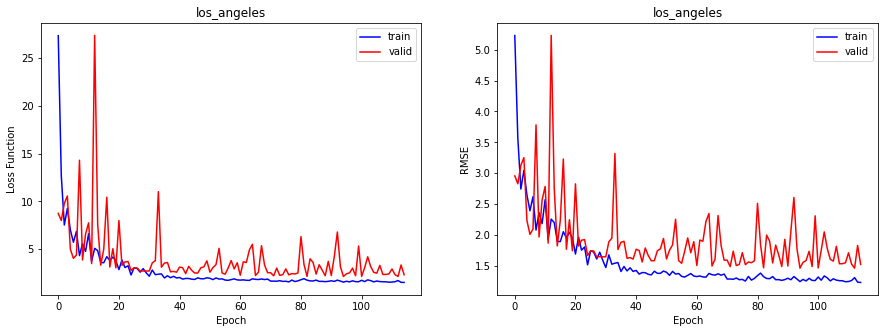

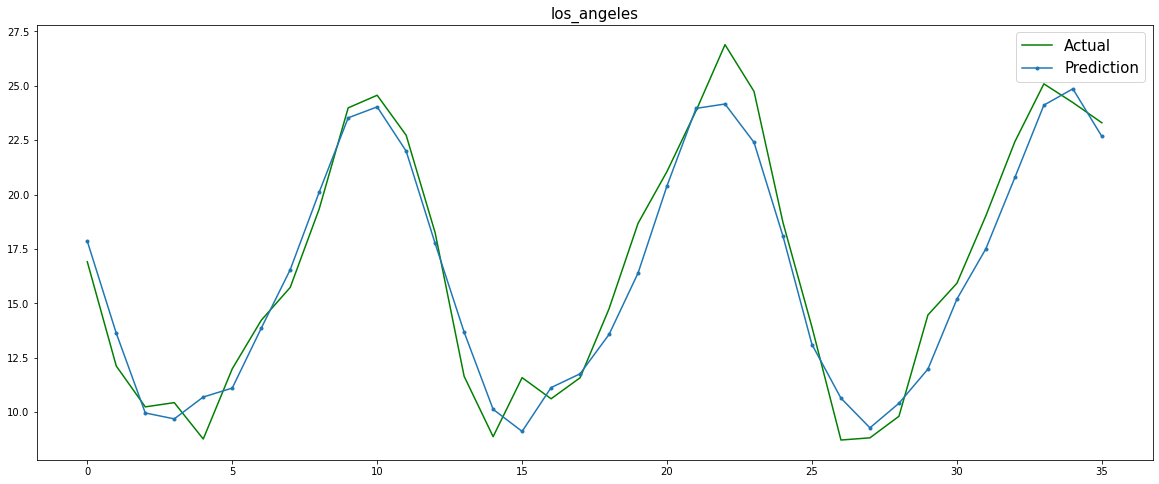

Test Loss:  1.7192902565002441
Test RMSE:  1.3112170696258545


In [70]:
los_angeles_score = city_model('los_angeles')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 14.0857 - root_mean_squared_error: 3.7531 - val_loss: 4.6485 - val_root_mean_squared_error: 2.1560
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.8928 - root_mean_squared_error: 2.4275 - val_loss: 10.6695 - val_root_mean_squared_error: 3.2664
Epoch 3/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.1221 - root_mean_squared_error: 2.0303 - val_loss: 7.3914 - val_root_mean_squared_error: 2.7187
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.6209 - root_mean_squared_error: 1.9029 - val_loss: 2.0265 - val_root_mean_squared_error: 1.4235
Epoch 5/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.6699 - root_mean_squared_error: 1.6340 - val_loss: 1.6689 - val_root_mean_squared_error: 1.2919
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.5471 - root_mean_squared_error: 1.5960 - val_loss: 2.1244 - v

46/46 [==============================] - 0s 6ms/step - loss: 1.0124 - root_mean_squared_error: 1.0062 - val_loss: 1.9175 - val_root_mean_squared_error: 1.3848
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0172 - root_mean_squared_error: 1.0085 - val_loss: 1.9189 - val_root_mean_squared_error: 1.3852
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0888 - root_mean_squared_error: 1.0435 - val_loss: 1.2590 - val_root_mean_squared_error: 1.1220
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0110 - root_mean_squared_error: 1.0055 - val_loss: 1.3356 - val_root_mean_squared_error: 1.1557
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0228 - root_mean_squared_error: 1.0113 - val_loss: 2.3486 - val_root_mean_squared_error: 1.5325
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0854 - root_mean_squared_error: 1.0418 - val_loss: 1.5934 - val_root_mea

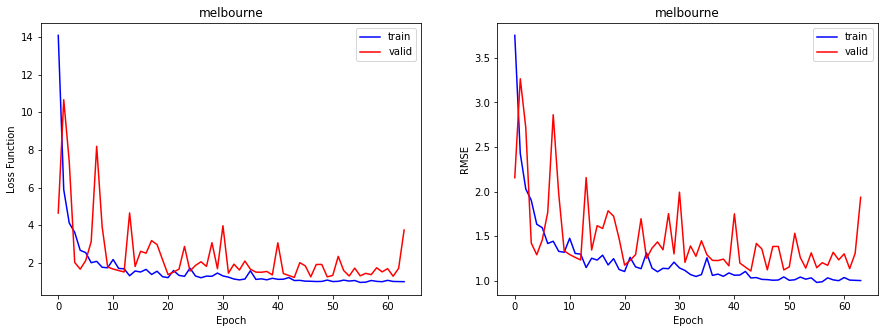

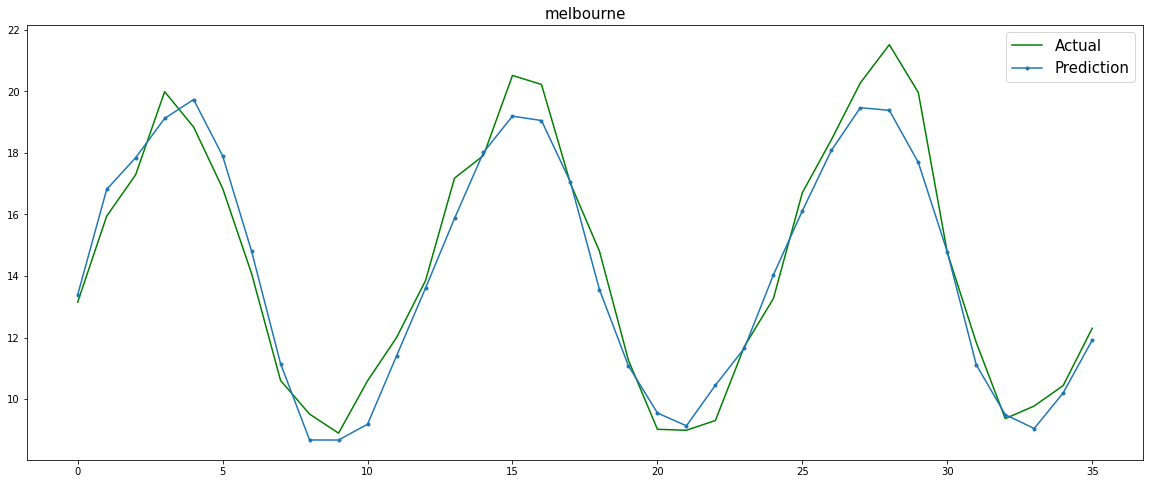

Test Loss:  0.7928659915924072
Test RMSE:  0.890430212020874


In [71]:
melbourne_score = city_model('melbourne')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 10.9936 - root_mean_squared_error: 3.3157 - val_loss: 4.5025 - val_root_mean_squared_error: 2.1219
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.2294 - root_mean_squared_error: 2.0566 - val_loss: 4.1556 - val_root_mean_squared_error: 2.0385
Epoch 3/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.6163 - root_mean_squared_error: 1.9016 - val_loss: 1.9790 - val_root_mean_squared_error: 1.4068
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.0133 - root_mean_squared_error: 1.7359 - val_loss: 3.1659 - val_root_mean_squared_error: 1.7793
Epoch 5/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.5257 - root_mean_squared_error: 1.5893 - val_loss: 3.1290 - val_root_mean_squared_error: 1.7689
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.0884 - root_mean_squared_error: 1.7574 - val_loss: 1.5556 - va

46/46 [==============================] - 0s 7ms/step - loss: 0.9623 - root_mean_squared_error: 0.9810 - val_loss: 0.8433 - val_root_mean_squared_error: 0.9183
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.9767 - root_mean_squared_error: 0.9883 - val_loss: 1.1265 - val_root_mean_squared_error: 1.0614
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.9748 - root_mean_squared_error: 0.9873 - val_loss: 1.1307 - val_root_mean_squared_error: 1.0633
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0868 - root_mean_squared_error: 1.0425 - val_loss: 1.2105 - val_root_mean_squared_error: 1.1002
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.9889 - root_mean_squared_error: 0.9945 - val_loss: 0.7864 - val_root_mean_squared_error: 0.8868
Epoch 53/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.1294 - root_mean_squared_error: 1.0627 - val_loss: 1.0347 - val_root_mea

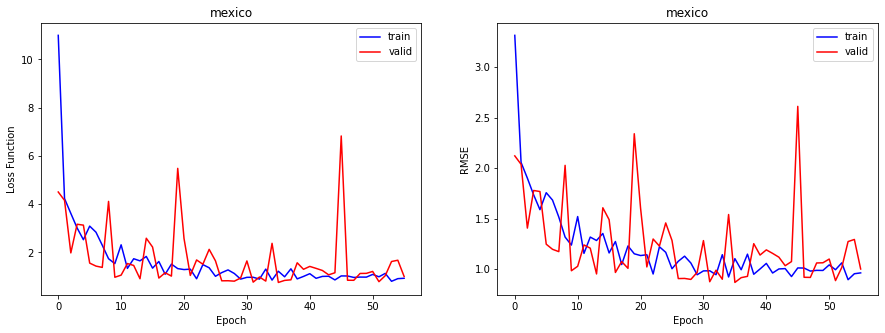

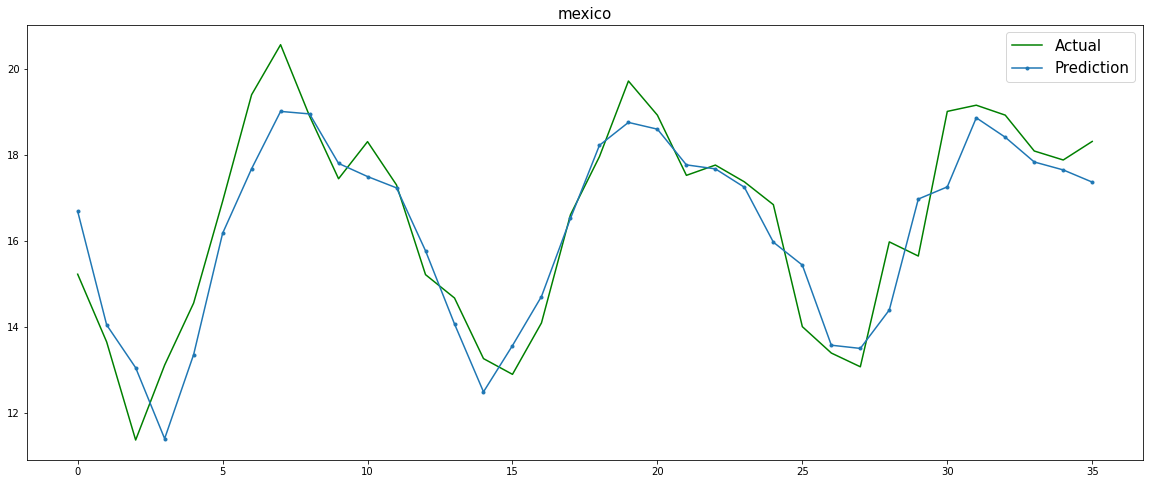

Test Loss:  0.8658263683319092
Test RMSE:  0.9304978847503662


In [72]:
mexico_score = city_model('mexico')

Epoch 1/1000
46/46 [==============================] - 1s 12ms/step - loss: 14.7742 - root_mean_squared_error: 3.8437 - val_loss: 6.1156 - val_root_mean_squared_error: 2.4730
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.0017 - root_mean_squared_error: 2.2365 - val_loss: 3.6945 - val_root_mean_squared_error: 1.9221
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.3964 - root_mean_squared_error: 2.0967 - val_loss: 4.3476 - val_root_mean_squared_error: 2.0851
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.6427 - root_mean_squared_error: 2.1547 - val_loss: 2.8396 - val_root_mean_squared_error: 1.6851
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.4804 - root_mean_squared_error: 2.1167 - val_loss: 3.0853 - val_root_mean_squared_error: 1.7565
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 4.0987 - root_mean_squared_error: 2.0245 - val_loss: 2.8847 - va

46/46 [==============================] - 0s 6ms/step - loss: 3.8463 - root_mean_squared_error: 1.9612 - val_loss: 3.1605 - val_root_mean_squared_error: 1.7778
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8584 - root_mean_squared_error: 1.9643 - val_loss: 2.5206 - val_root_mean_squared_error: 1.5876
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8418 - root_mean_squared_error: 1.9600 - val_loss: 2.5166 - val_root_mean_squared_error: 1.5864
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8212 - root_mean_squared_error: 1.9548 - val_loss: 4.7722 - val_root_mean_squared_error: 2.1845
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8872 - root_mean_squared_error: 1.9716 - val_loss: 2.5502 - val_root_mean_squared_error: 1.5969
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.7992 - root_mean_squared_error: 1.9492 - val_loss: 2.9935 - val_root_mea

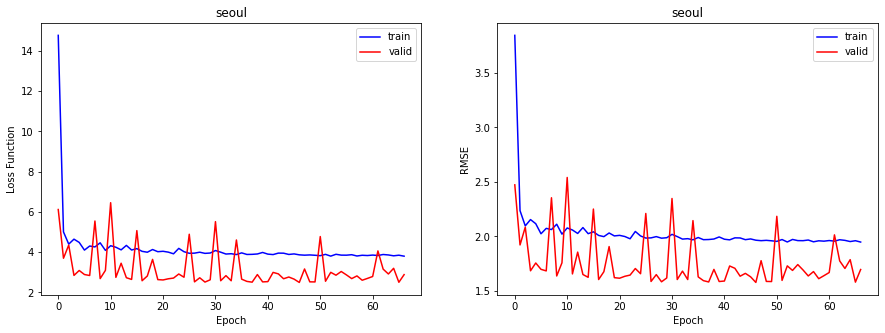

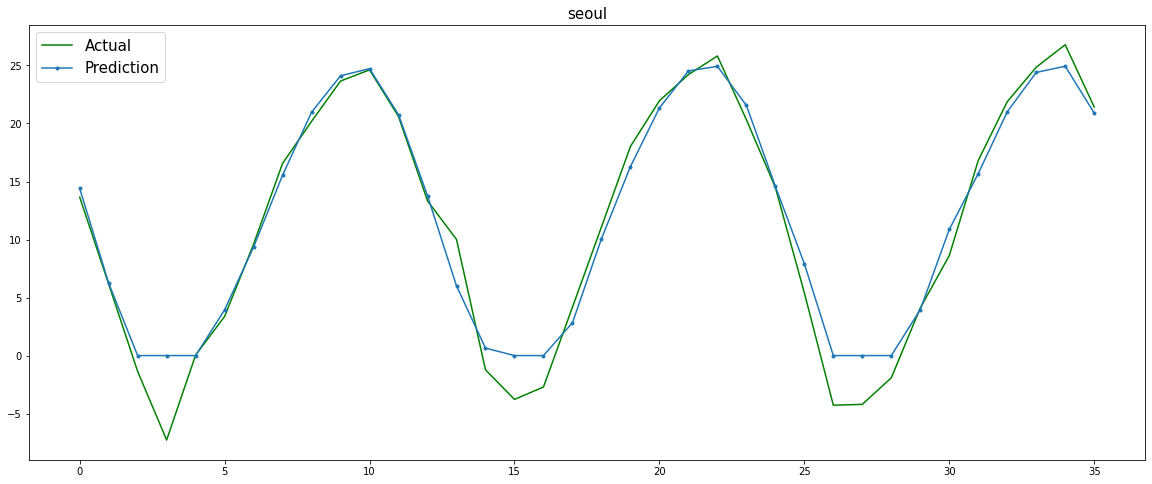

Test Loss:  4.57583475112915
Test RMSE:  2.139120101928711


In [73]:
seoul_score = city_model('seoul')

Epoch 1/1000
46/46 [==============================] - 1s 11ms/step - loss: 33.5845 - root_mean_squared_error: 5.7952 - val_loss: 5.1679 - val_root_mean_squared_error: 2.2733
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 13.4511 - root_mean_squared_error: 3.6676 - val_loss: 21.1471 - val_root_mean_squared_error: 4.5986
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 8.3071 - root_mean_squared_error: 2.8822 - val_loss: 8.8681 - val_root_mean_squared_error: 2.9779
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 7.2612 - root_mean_squared_error: 2.6947 - val_loss: 3.7327 - val_root_mean_squared_error: 1.9320
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.8671 - root_mean_squared_error: 2.4222 - val_loss: 2.5273 - val_root_mean_squared_error: 1.5898
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.8654 - root_mean_squared_error: 2.4219 - val_loss: 6.2536 - 

46/46 [==============================] - 0s 6ms/step - loss: 1.3307 - root_mean_squared_error: 1.1535 - val_loss: 5.1473 - val_root_mean_squared_error: 2.2688
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.7857 - root_mean_squared_error: 1.3363 - val_loss: 1.8381 - val_root_mean_squared_error: 1.3557
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5348 - root_mean_squared_error: 1.2389 - val_loss: 1.6546 - val_root_mean_squared_error: 1.2863
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.4061 - root_mean_squared_error: 1.1858 - val_loss: 2.0171 - val_root_mean_squared_error: 1.4202
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.4693 - root_mean_squared_error: 1.2122 - val_loss: 1.5686 - val_root_mean_squared_error: 1.2524
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5214 - root_mean_squared_error: 1.2335 - val_loss: 1.7480 - val_root_mea

46/46 [==============================] - 0s 6ms/step - loss: 1.3619 - root_mean_squared_error: 1.1670 - val_loss: 1.8284 - val_root_mean_squared_error: 1.3522
Epoch 96/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.3069 - root_mean_squared_error: 1.1432 - val_loss: 1.5420 - val_root_mean_squared_error: 1.2418
Epoch 97/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.3230 - root_mean_squared_error: 1.1502 - val_loss: 1.6086 - val_root_mean_squared_error: 1.2683
Epoch 98/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.4558 - root_mean_squared_error: 1.2066 - val_loss: 1.9412 - val_root_mean_squared_error: 1.3933
Epoch 99/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.4530 - root_mean_squared_error: 1.2054 - val_loss: 1.4452 - val_root_mean_squared_error: 1.2022
Epoch 100/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.2866 - root_mean_squared_error: 1.1343 - val_loss: 1.9032 - val_root_me

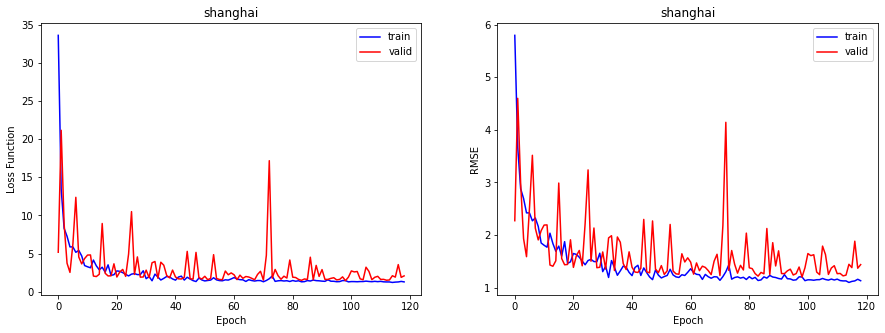

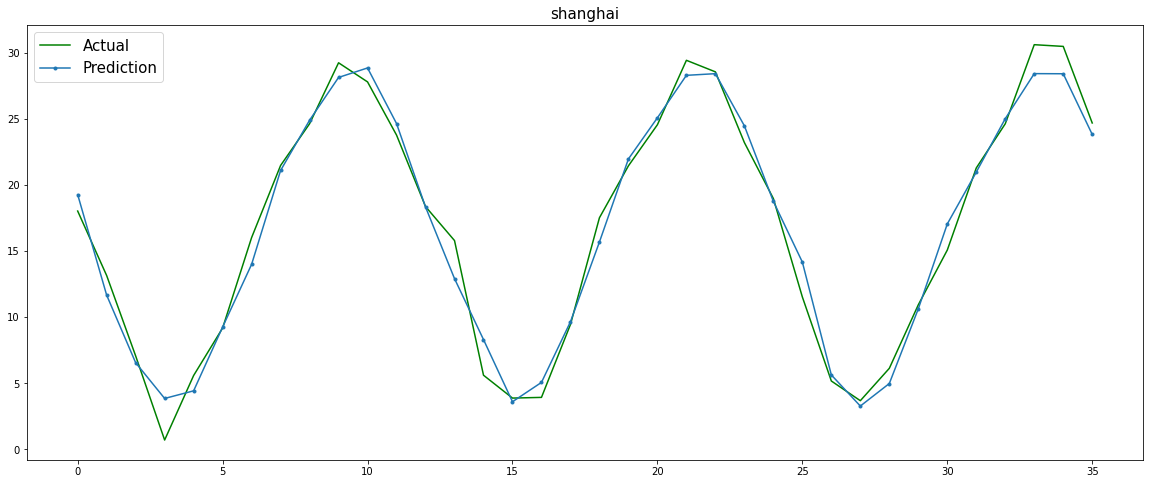

Test Loss:  1.9250223636627197
Test RMSE:  1.3874517679214478


In [78]:
shanghai_score = city_model('shanghai')

In [82]:
city_list = [berlin_score, cairo_score, london_score, los_angeles_score, \
            melbourne_score, mexico_score, seoul_score, shanghai_score]
city_df = pd.DataFrame(city_list, index=city, columns=['Loss', 'RMSE'])

In [83]:
city_df

,Loss,RMSE
berlin,4.131607,2.032635
cairo,1.694731,1.301818
london,2.540540,1.593907
los_angeles,1.719290,1.311217
melbourne,0.792866,0.890430
mexico,0.865826,0.930498
seoul,4.575835,2.139120
shanghai,1.925022,1.387452
